In [ ]:
import json
import random
from copy import deepcopy
from dataclasses import dataclass
from typing import List
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BartForConditionalGeneration
from transformers import PreTrainedTokenizerFast

from data_utils import split_slot

In [ ]:
data = json.load(open('data/train_dataset/train_dials.json'))

# Preliminary 

## Pretrained Language Model based on Encoder-Decoder Architecture

Transformer의 Encoder 구조를 활용한 Bidirectional Encoder LM (BERT), Decoder 구조를 활용한 Autoregressive LM (GPT-2)의 성공 이후에 Encoder + Decoder 구조를 모두 활용한 LM이 제시되었고, NLP Task 전반적으로 높은 성능을 기록했습니다. CoCo의 Generation 모델 소개에 앞서 BART, T5 등 Encoder+Decoder 구조의 LM을 소개합니다.


## 🌟 BART 🌟

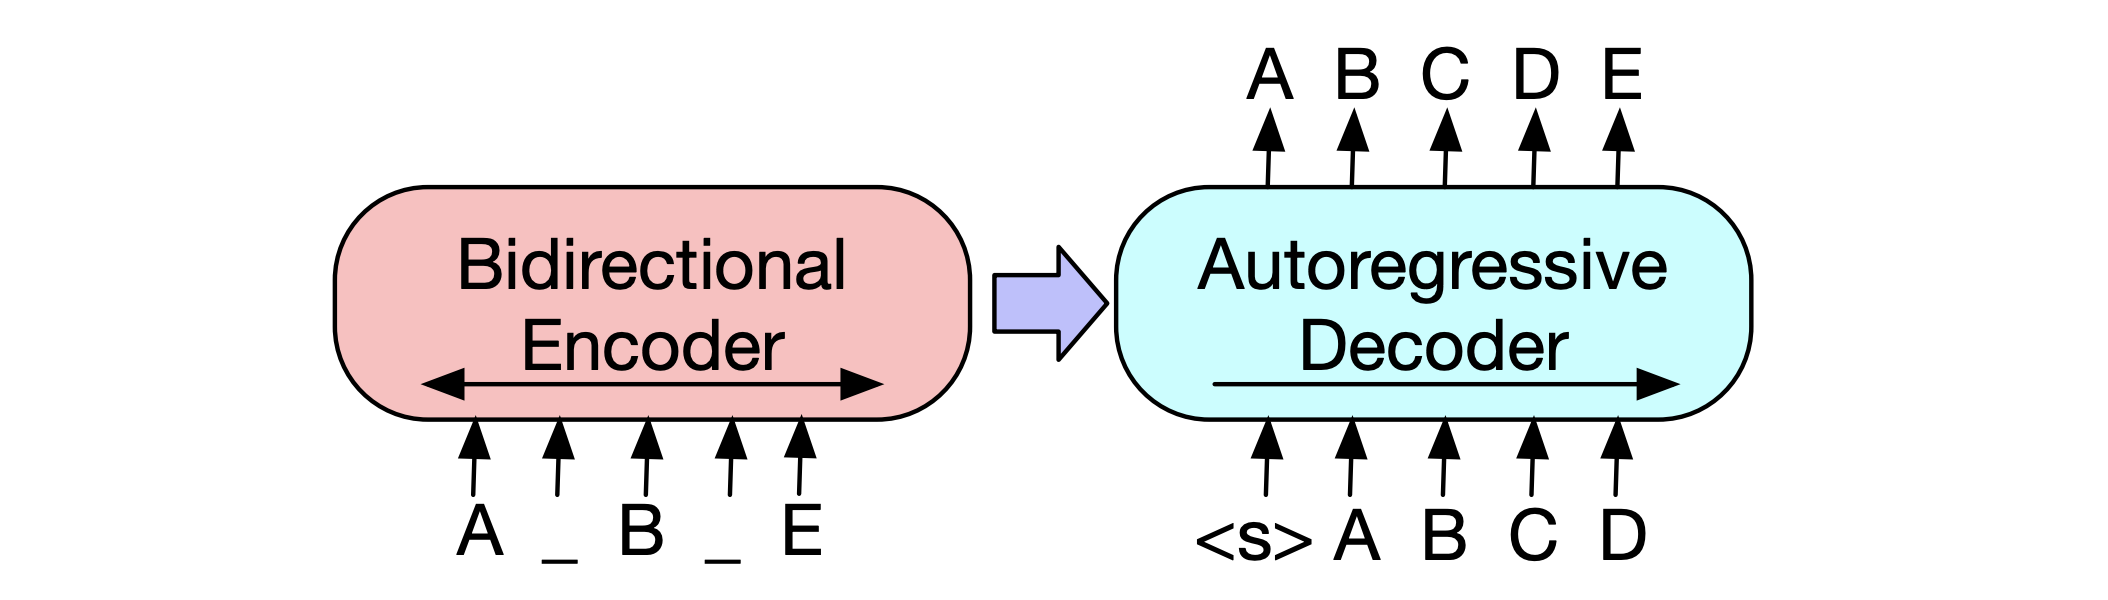

BART는 Transformer 기반 모델인 BERT와 GPT를 합친 Encoder + Decoder 모델입니다.

BART는 Facebook AI에서 제안한 모델로, Bidirectional and Auto-Regressive Transformer가 모델의 이름의 풀네임이지만 논문 제목은 Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension입니다 . 

모델 이름을 통해 아래와 같은 특징을 유추 해볼 수 있습니다.

1) 이 모델은 Sequence to Sequence구조를 가질것 

2) 이 구조가 Bidirectional 과 Auto Regressive Transformer의 장점을 모두 갖출 것 

3) Denoising이라는 단어가 등장한 것으로 보아 새로운 noise (MASK) 방법을 보일 것

보다 자세한 설명은 아래의 자료를, 요약된 정리는 영상  (24:40 ~ 28:16)을 참고하세요 😎 

논문 : [BART Paper](https://arxiv.org/pdf/1910.13461.pdf)


자료 : [BART 자료](https://drive.google.com/file/d/1XHw0KVUZRGXVeu4y2T3PGWtKyMyCzAyK/view?usp=sharing)


영상 : [Transformer to T5](https://www.youtube.com/watch?v=v7diENO2mEA&ab_channel=KoreaUnivDSBA)

## 🔥 T5 🔥

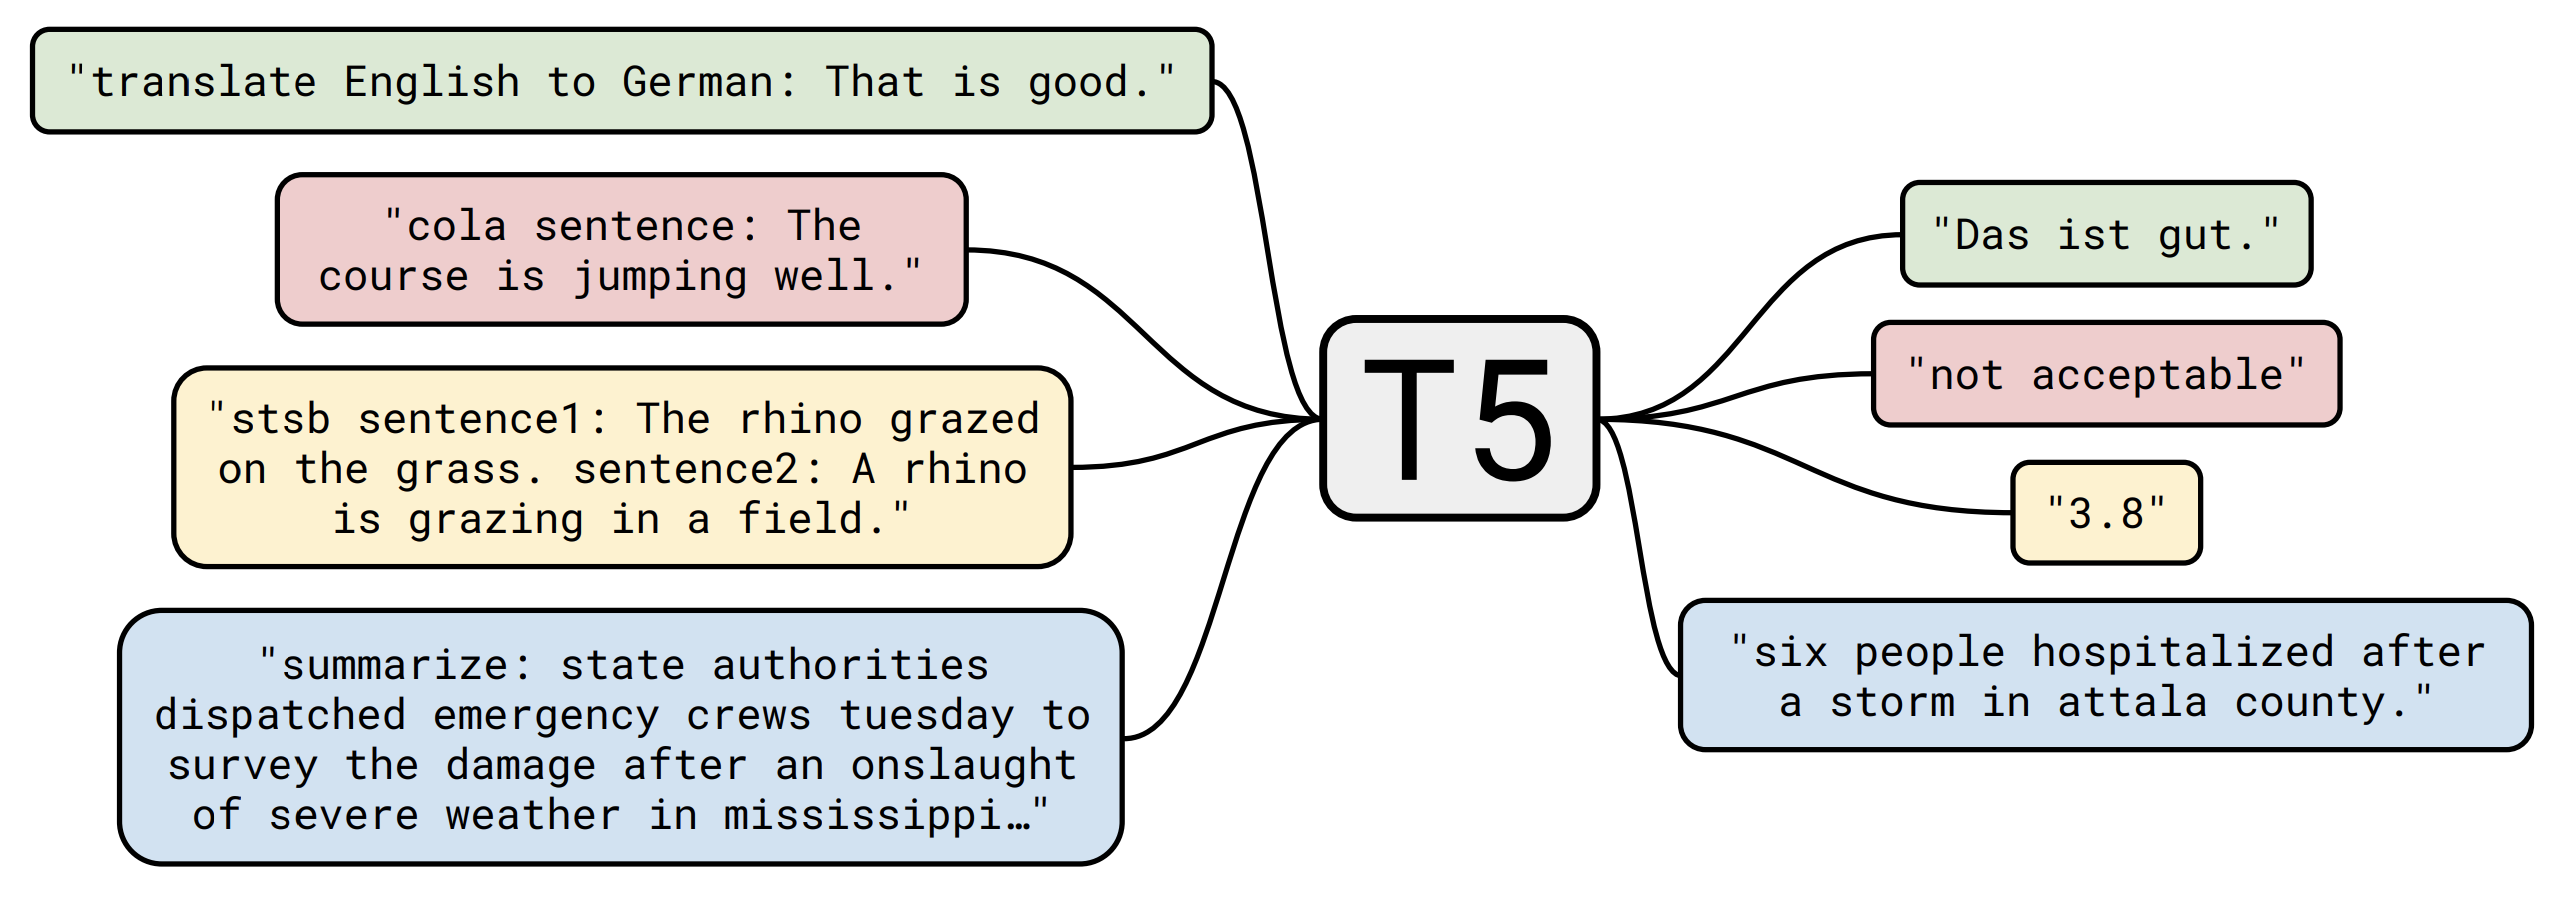

T5 또한 Transformer 기반 모델로서 Basic한 Transfomer의 Encoder + Decoder 구조로 이루어져 있습니다.

T5는 구글에서 제안한 모델로, GPT3가 나오기 이전까지 SOTA를 기록한 모델입니다. 정확한 풀네임은 Text to text transfer transformer 이며, basic transformer encoder-decoder를 적용한 모델이기에 BERT와 GPT를 쌓았던 기존 모델과는 또 다른 모습을 보여줍니다. 이 모델은 General한 Language Model을 만들기 위해 단일 모델이 multi task learning을 진행합니다. 

모델 이름에서 이미 언급하듯, 가장 중요한 포인트는 Text to Text Transfer를 진행하는 trasformer 모델이라는 점입니다. 
**텍스트를 텍스트로 변환**한다는게 가장 중요할텐데요, 아래의 자료와 요약 영상(32:44~)을 통해 자세한 내용을 확인하세요 😌

논문 : [T5 Paper](https://arxiv.org/pdf/1910.10683.pdf)
(논문은,, 67페이지이므로 자료와 영상 보는걸 추천드려요 😖)

자료 : [T5 자료](https://drive.google.com/file/d/1Rx7Pmp2YK5SQXNG0vfnkn3nGmyNbUse3/view?usp=sharing)

영상 : [Transformer to T5](https://www.youtube.com/watch?v=v7diENO2mEA&ab_channel=KoreaUnivDSBA)

In [ ]:
# Load model and Tokenizer : 공개된 SKT Korean bart를 불러옵니다 
# Kobart에 대한 자세한 설명은 다음의 링크를 참고하세요 : https://github.com/hyunwoongko/kobart-transformers

model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart")
tokenizer = PreTrainedTokenizerFast.from_pretrained("hyunwoongko/kobart")

✅ **BART tokenizer 참고** ✅

BART는 BERT와는 다른 형태의 special token을 가지니 주의하세요 !

* bos는 'begin of sentence', eos는 'end of sentence' 를 의미합니다
* bos_token=`<s>`, eos_token=`</s>`, unk_token=`<unk>`, pad_token=`<pad>` , mask_token= `<mask>` 



# Conditional user utterance generation model

## InputExample 및 Feature 정의, 추출 

In [ ]:
@dataclass
class CoCoGenInputExample:
    guid: str
    system_utter: str
    turn_state: List[str]
    user_utter: str

@dataclass
class CoCoGenInputFeature:
    input_id: List[int]
    target_id: List[int]

In [ ]:
def get_coco_examples_from_dialogue(dialogue):
    """ Dialogue 데이터셋 파일 -> CoCoGenInputExamples """
    guid = dialogue["dialogue_idx"]
    examples = []
    d_idx = 0
    previous_state = []
    for idx, turn in enumerate(dialogue["dialogue"]):
        if turn["role"] != "user":
            continue

        if idx:
            sys_utter = dialogue["dialogue"][idx - 1]["text"]
        else:
            sys_utter = ""

        user_utter = turn["text"]
        state = turn.get("state")

        turn_state = sorted(list(set(state) - set(previous_state)))
        examples.append(CoCoGenInputExample(guid=f"{guid}-{d_idx}",
                                            system_utter=sys_utter,
                                            turn_state=turn_state,
                                            user_utter=user_utter))

        d_idx += 1
        previous_state = state

    return examples


def convert_example_to_feature(example, tokenizer):
    """ CoCoGenInputExamples -> CoCoGenInputFeature """
    sys = tokenizer.tokenize(example.system_utter)
    turn_state = ', '.join([s.replace('-', ' ') for s in example.turn_state])
    state = tokenizer.tokenize(turn_state)
    user = [tokenizer.bos_token] + tokenizer.tokenize(example.user_utter) + [tokenizer.eos_token]

    input_tokens = [tokenizer.bos_token] + sys + [tokenizer.eos_token] + state + [tokenizer.eos_token]
    input_id = tokenizer.convert_tokens_to_ids(input_tokens)
    target_id = tokenizer.convert_tokens_to_ids(user)

    return CoCoGenInputFeature(input_id=input_id, target_id=target_id)


def pad_ids(arrays, pad_idx, max_length=-1):
    if max_length < 0:
        max_length = max(list(map(len, arrays)))

    arrays = [array + [pad_idx] * (max_length - len(array)) for array in arrays]
    return arrays


def collate_fn(batch):
    input_ids = torch.LongTensor(pad_ids([b.input_id for b in batch], tokenizer.pad_token_id))
    target_ids = torch.LongTensor(pad_ids([b.target_id for b in batch], -100))
    input_masks = input_ids.ne(tokenizer.pad_token_id).float()
    return input_ids, target_ids, input_masks


In [ ]:
examples = []
for dialogue in tqdm(data):
    examples.extend(get_coco_examples_from_dialogue(dialogue))

features = []
for example in tqdm(examples):
    features.append(convert_example_to_feature(example, tokenizer))

100%|██████████| 51245/51245 [00:17<00:00, 2925.65it/s]


## Data Loader 및 Optimization 준비 

In [ ]:
num_train_epochs = 10
batch_size = 32
lr = 5e-5
warmup_ratio = 0.1
weight_decay = 0.01

n_gpu = torch.cuda.device_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CoCoGenDataset(Dataset):
    def __init__(self, features):
        self.features = features
        self.length = len(self.features)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.features[idx]

train_data = CoCoGenDataset(features)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)

In [ ]:
t_total = len(train_loader) * num_train_epochs
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(t_total * warmup_ratio), num_training_steps=t_total
)

model.to(device)
print("")

## Train

In [ ]:
for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_loader):
        input_ids, target_ids, input_masks = (b.to(device) for b in batch)
        decoder_input_ids = target_ids[:, :-1].contiguous() 
        decoder_input_ids[decoder_input_ids == -100] = tokenizer.pad_token_id
        labels = target_ids[:, 1:].clone()
        outputs = model(input_ids,
                        attention_mask=input_masks,
                        decoder_input_ids=decoder_input_ids,
                        labels=labels)
        loss = outputs[0]
        if n_gpu > 1:
            loss = loss.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            print(f"[{epoch}/{num_train_epochs}][{step}/{len(train_loader)}] {loss}")

[0/10][0/1602] 14.67784309387207
[0/10][100/1602] 4.923025131225586
[0/10][200/1602] 3.1154143810272217
[0/10][300/1602] 2.8315181732177734
[0/10][400/1602] 2.603085517883301
[0/10][500/1602] 2.495835781097412
[0/10][600/1602] 2.3101766109466553
[0/10][700/1602] 2.210387945175171
[0/10][800/1602] 2.0387189388275146
[0/10][900/1602] 2.061370849609375
[0/10][1000/1602] 1.985012412071228
[0/10][1100/1602] 1.8828710317611694
[0/10][1200/1602] 1.9668684005737305
[0/10][1300/1602] 1.7343682050704956
[0/10][1400/1602] 1.8588690757751465
[0/10][1500/1602] 1.7015140056610107
[0/10][1600/1602] 1.6432664394378662
[1/10][0/1602] 1.735448956489563
[1/10][100/1602] 1.687031626701355
[1/10][200/1602] 1.8339781761169434
[1/10][300/1602] 1.599918246269226
[1/10][400/1602] 2.051422357559204
[1/10][500/1602] 1.6595312356948853
[1/10][600/1602] 1.8826745748519897
[1/10][700/1602] 1.7339762449264526
[1/10][800/1602] 1.8476755619049072
[1/10][900/1602] 1.5863310098648071
[1/10][1000/1602] 1.6401946544647217

## Inference 



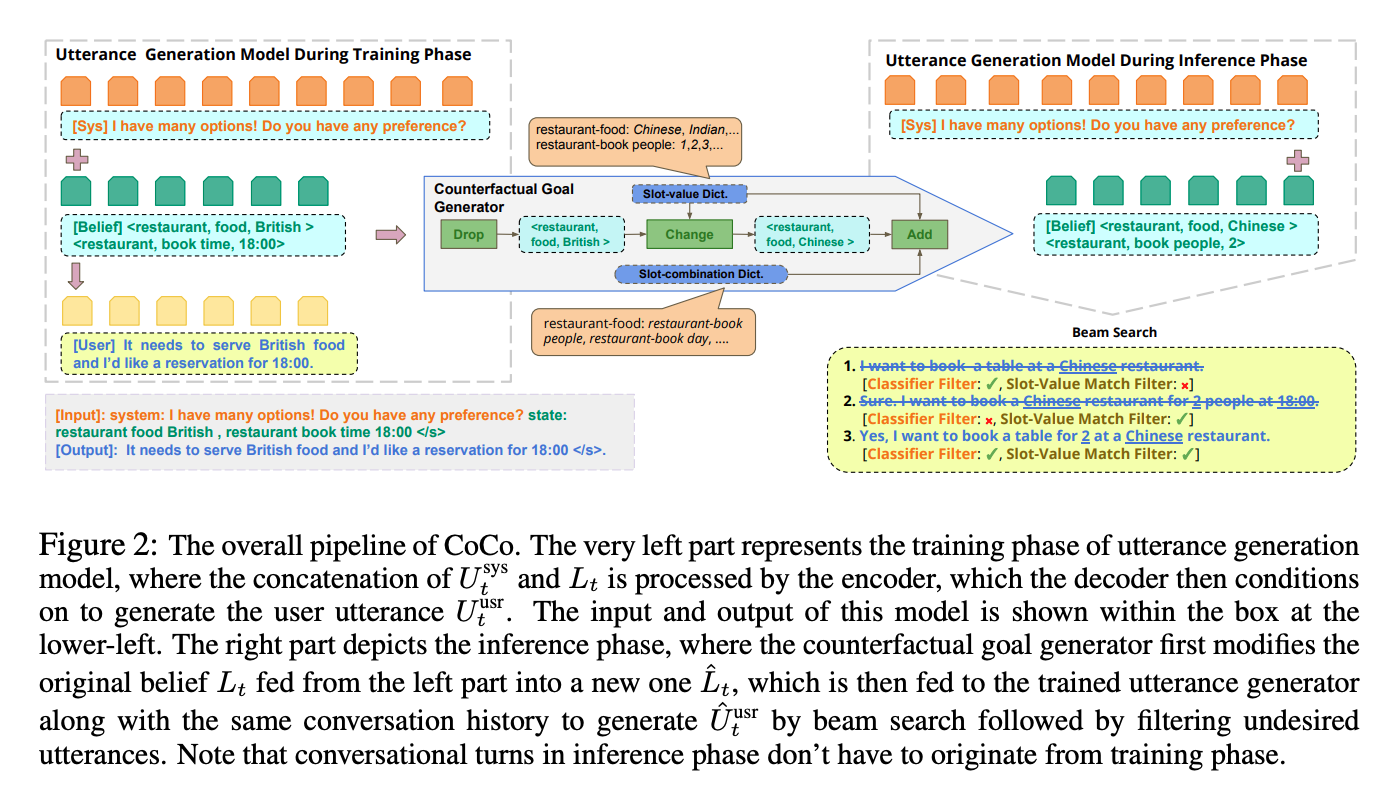

In [ ]:
def coco_generator(example, slot_value_dict, slot_comb_dict={}, verbose=False):
    if not example.turn_state:
        return example

    coco = deepcopy(example)
    num_state = len(coco.turn_state)
    is_drop = False

    # drop: dialogue state 중 하나를 제거합니다. (e.g., [식당-종류-양식당, 식당-예약 시간-18:00] -> [식당-종류-양식당])
    if num_state > 1:
        drop_idx = random.choice(range(num_state))
        coco.turn_state.pop(drop_idx)
        num_state -= 1
        is_drop = True

    # change: dialogue state의 value 중 하나를 다른 value로 대체합니다. (e.g., [식당-종류-양식당] -> [식당-종류-중식당])
    change_idx = random.choice(range(num_state))
    origin_slot_value = coco.turn_state[change_idx]
    st, sv = split_slot(origin_slot_value, True)
    candidates = slot_value_dict.get(st, [sv])
    new_sv = random.choice(candidates[1:])
    new_slot_value = f"{st}-{new_sv}"
    coco.turn_state[change_idx] = new_slot_value

    # add: slot_comb_dict에서 하나의 slot-value를 생성합니다. (e.g., [식당-종류-중식당] -> [식당-종류-중식당, 식당-예약 인원-2])
    combinations = slot_comb_dict.get(st)

    if not combinations:
        return coco

    co_st = random.choice(combinations)
    candidates = slot_value_dict.get(co_st, ['dontcare'])
    co_sv = random.choice(candidates[1:])
    new_slot_value = f"{co_st}-{co_sv}"
    coco.turn_state.append(new_slot_value)

    if verbose:
        print("Before:", example.turn_state)
        print("After:", coco.turn_state)

    return coco

## Dictionary 

* Slot Value dictionary: Ontology로 대체 (새로운 value를 추가해보세요)
* Slot Comb Dictionary: "숙소" 도메인에 한정해서만 임의로 생성 (직접 확장해보세요.)

In [ ]:
slot_value_dict = json.load(open('data/train_dataset/ontology.json'))

In [ ]:
slot_comb_dict = {
    '숙소-가격대': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-종류': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-지역': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-인터넷 가능': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-주차 가능': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-흡연 가능': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-조식 가능': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-헬스장 유무': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-수영장 유무': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간'],
    '숙소-스파 유무': ['숙소-예약 명수', '숙소-예약 요일', '숙소-예약 기간']
}

In [ ]:
x = random.choice(examples)
x = coco_generator(x, slot_value_dict, slot_comb_dict, verbose=True)
x = convert_example_to_feature(x, tokenizer)

Before: ['숙소-종류-게스트 하우스', '숙소-지역-서울 중앙']
After: ['숙소-지역-서울 남쪽', '숙소-예약 요일-목요일']


In [ ]:
print("input:", tokenizer.decode(x.input_id))

input: <s></s> 숙소 지역 서울 남쪽, 숙소 예약 요일 목요일</s>


In [ ]:
#Huggingface의 BartForConditionalGeneration은 model.generate를 통해 쉽게 generation을 진행할 수 있습니다 🙌🏻
input_id = torch.LongTensor([x.input_id]).to(device)
o = model.generate(input_id,
                   decoder_start_token_id=tokenizer.bos_token_id,
                   bos_token_id=tokenizer.bos_token_id,
                   eos_token_id=tokenizer.eos_token_id,
                   pad_token_id=tokenizer.pad_token_id,
                   max_length=30,
                   early_stopping=True,
                   num_beams=8,
                   top_k=30,
                   temperature=1.5,
                   do_sample=True)
q = tokenizer.decode(o.tolist()[0], skip_special_tokens=True)

In [ ]:
print("Before:", tokenizer.decode(x.target_id, skip_special_tokens=True))
print("After:", q)

Before: 서울 중앙에 있는 게스트 하우스 찾아줘요~
After: 서울 남쪽에 목요일에 예약 가능한 숙소가 있나요?


## TODO 

현재는 conditional user utterance generation model 학습 및 추론 코드만 제공되어 있습니다. 생성한 utterance를 dialogue data로 가공하여 data augmentation을 완성하고, 이를 이용해서 학습을 진행해봅시다. 

1. 2가지 filtering method를 적용해보세요. (Classifier (BERT/RoBERTA-based) Filter, Slot Value match Filter)
  - Slot Value match Filter: 있어야 하는 slot-value pair가 나타나지 않는 utterance를 제외합니다. (de-generation)
  - Classifier Filter: 나타나야 하는 slot-value pair 이외에 다른 slot-value가 나타나는 utterance를 제외합니다. (over-generation) 

2. Turn-level의 인스턴스를 Dialogue-level로 확장하여 대화를 Augmentation 해보세요.
3. Augmented Dialogue를 이용하여 학습에 사용해보세요.